In [2]:
import pandas as pd
from pathlib import Path

from main import boxes

#Trial
df = pd.read_csv("./PRAKHAR_IIITD/Arousal/28M_NE_C.csv")
print(df.columns)

Index(['Unnamed: 0', 'experiment_id', 'session_id', 'device_id', 'event_id',
       'type', 'device_time', 'logged_time', 'time', 'confidence_interval',
       'delay', 'filter_id', 'eye', 'gaze_x', 'gaze_y', 'gaze_z', 'eye_cam_x',
       'eye_cam_y', 'eye_cam_z', 'angle_x', 'angle_y', 'raw_x', 'raw_y',
       'pupil_measure1', 'pupil_measure1_type', 'pupil_measure2',
       'pupil_measure2_type', 'ppd_x', 'ppd_y', 'velocity_x', 'velocity_y',
       'velocity_xy', 'status', 'participant_id', 'pixel_x', 'pixel_y'],
      dtype='object')


In [4]:


# Set your dataset base folder and bounding box file
# making life easier by defining data root for simple file handling
DATA=Path("./PRAKHAR_IIITD/")

BBOX_FILE= "Bounding_Box.xlsx"

# Output folder for results
output = Path("./results")
output.mkdir(exist_ok=True)

# Load bounding box information
bbox = pd.read_excel(BBOX_FILE)
print("Bounding box file loaded:", bbox.shape)
print(bbox.head())

Bounding box file loaded: (180, 8)
  label_name  bbox_x  bbox_y  bbox_width  bbox_height    image_name  \
0       Eyes     121     233         260          119  01F_HA_X.BMP   
1      Mouth     151     444         194           90  01F_HA_X.BMP   
2       Nose     164     354         167           87  01F_HA_X.BMP   
3       Eyes     121     233         260          119  02F_AN_C.BMP   
4      Mouth     151     444         194           90  02F_AN_C.BMP   

   image_width  image_height  
0          506           626  
1          506           626  
2          506           626  
3          506           650  
4          506           650  


In [7]:
# Since we would have to repeat processes for multiple files, having them as functions here:
#-> there are many participants (in participant_id of
#-> they are presented with images of faces from a database, on which they have to perform 3 tasks: categorization, arousal, valence.
#-> their eyemoments are tracked.
#-> each csv data file has multiple participants whose activity is recorded for that image. The dimensions of image are stored in bounded_box.csv.

#-------------------------
#also .bmp images can be linked to .csv in dataset, to get corresponding bbox data.
def csv_link_img(csv_file: Path) -> str:
    # print(csv_file.stem + "BMP")
    return csv_file.stem + ".BMP"
def getEmotion(csv_file: Path) -> str:
    if "_AN_" in csv_file.stem:
        return "AN"
    elif "_HA_" in csv_file.stem:
        return "HA"
    elif "_NE_" in csv_file.stem:
        return "NE"
    return "unknown emotion, ??????"

def detect_saccades(df):
    if "time" in df.columns:
        df = df.sort_values("time")
    dx = df["pixel_x"].diff().abs()
    dy = df["pixel_y"].diff().abs()
    mask = (dx >= 30) | (dy >= 30)
    return df.loc[mask, ["pixel_x", "pixel_y"]].head(5).reset_index(drop=True)

def point_to_aoi(x, y, boxes):
    for i, r in boxes.iterrows():
        x0, y0 = float(r["bbox_x"]), float(r["bbox_y"])
        x1 = x0 + float(r["bbox_width"])
        y1 = y0 + float(r["bbox_height"])
        if x0 <= x <= x1 and y0 <= y <= y1:
            return r["label_name"]
    return "Outside"


In [17]:
raw=[]

tasks=["Arousal", "Categorisation", "Valence"]
# iterate in three folders, as given in dataset
for i in tasks:
    task_path= DATA/i
    raw1=[]
    # iterating through each csv in the task folder
    for j in task_path.glob("*.csv"):
        df= pd.read_csv(j)
        if df[['pixel_x','pixel_y']].dropna(how='any').empty:
            continue

        imgx=csv_link_img(j)
        #print(imgx)
        emotion=getEmotion(j)
        boxes=bbox[bbox["image_name"] == imgx]

        # since each csv is actually observations on different participants, who react to the image shown.
        # there are multiple participants with unique participant_id, so lets group them to get saccades for every one of them.
        # !><><!
        # iterating through the participants in a csv
        #pid -> participant ID, by which we grouped our df
        #pdf -> dataframe of that particular participant.
        for pid , pdf in df.groupby("participant_id"):
            sac_df = detect_saccades(pdf)
            if sac_df.empty:
                continue
            aois = [point_to_aoi(x, y, boxes) for x, y in sac_df[["pixel_x","pixel_y"]].values]
            while len(aois) < 5:
                aois.append("NA")
            raw.append({
                "participant_id": pid,
                "image_name": imgx,
                "task": i,
                "emotion": emotion,
                "sac1": aois[0],
                "sac2": aois[1],
                "sac3": aois[2],
                "sac4": aois[3],
                "sac5": aois[4],
            })
            raw1.append({
                "participant_id": pid,
                "image_name": imgx,
                "task": i,
                "emotion": emotion,
                "sac1": aois[0],
                "sac2": aois[1],
                "sac3": aois[2],
                "sac4": aois[3],
                "sac5": aois[4]
            })
    xck_df=pd.DataFrame(raw1)
    xck_df.to_csv(output/f"{i}.csv", index=False)

raw_df = pd.DataFrame(raw)
print("\nRaw Saccades Table:", raw_df.shape)
raw_df.to_csv(output / "RawSaccades_All.csv", index=False)
raw_df.head(10)



Raw Saccades Table: (494, 9)


,participant_id,image_name,task,emotion,sac1,sac2,sac3,sac4,sac5
0,ANT,34M_HA_X.BMP,Arousal,HA,Nose,Nose,Nose,Nose,Nose
1,AUN,34M_HA_X.BMP,Arousal,HA,Outside,Outside,NA,NA,NA
2,CHN,34M_HA_X.BMP,Arousal,HA,Mouth,NA,NA,NA,NA
3,DHA,34M_HA_X.BMP,Arousal,HA,Eyes,Eyes,Eyes,Eyes,Eyes
4,HAH,34M_HA_X.BMP,Arousal,HA,Eyes,Nose,Eyes,NA,NA
5,HMN,34M_HA_X.BMP,Arousal,HA,Nose,Nose,Mouth,Nose,Nose
6,KUL,34M_HA_X.BMP,Arousal,HA,Nose,Nose,Nose,Outside,Nose
7,PRA,34M_HA_X.BMP,Arousal,HA,Nose,Nose,Eyes,Eyes,Outside
8,SHI,34M_HA_X.BMP,Arousal,HA,Nose,Outside,Outside,Outside,Outside
9,SYE,34M_HA_X.BMP,Arousal,HA,Mouth,Outside,Mouth,Mouth,Nose


In [20]:
summary = (
    raw_df.melt(
        id_vars=["participant_id", "task", "emotion"],
        value_vars=["sac1", "sac2", "sac3", "sac4", "sac5"],
        var_name="saccade", value_name="AOI"
    )
    .groupby(["participant_id", "task", "emotion", "AOI"])
    .size()
    .groupby(level=[0, 1, 2])
    .apply(lambda x: x / x.sum())
)

summary.index = summary.index.droplevel(0).droplevel(0).droplevel(0)

summary = summary.reset_index().rename(columns={0: "probability"})

print("Summary Table:", summary.shape)
summary.to_csv(output / "SaccadeProbabilities_All.csv", index=False)
summary.head(10)

Summary Table: (701, 5)


,participant_id,task,emotion,AOI,probability
0,ADA,Categorisation,AN,Eyes,0.2
1,ADA,Categorisation,AN,NA,0.6
2,ADA,Categorisation,AN,Outside,0.2
3,ADA,Categorisation,NE,Eyes,0.2
4,ADA,Categorisation,NE,NA,0.2
5,ADA,Categorisation,NE,Nose,0.2
6,ADA,Categorisation,NE,Outside,0.4
7,ADA,Valence,AN,Eyes,0.6
8,ADA,Valence,AN,NA,0.4
9,ADA,Valence,NE,Eyes,0.3


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

summary_path = Path("./results/SaccadeProbabilities_All.csv")
summary = pd.read_csv(summary_path)

print("Loaded summary:", summary.shape)
summary.head()

Loaded summary: (701, 5)


,participant_id,task,emotion,AOI,probability
0,ADA,Categorisation,AN,Eyes,0.2
1,ADA,Categorisation,AN,NaN,0.6
2,ADA,Categorisation,AN,Outside,0.2
3,ADA,Categorisation,NE,Eyes,0.2
4,ADA,Categorisation,NE,NaN,0.2


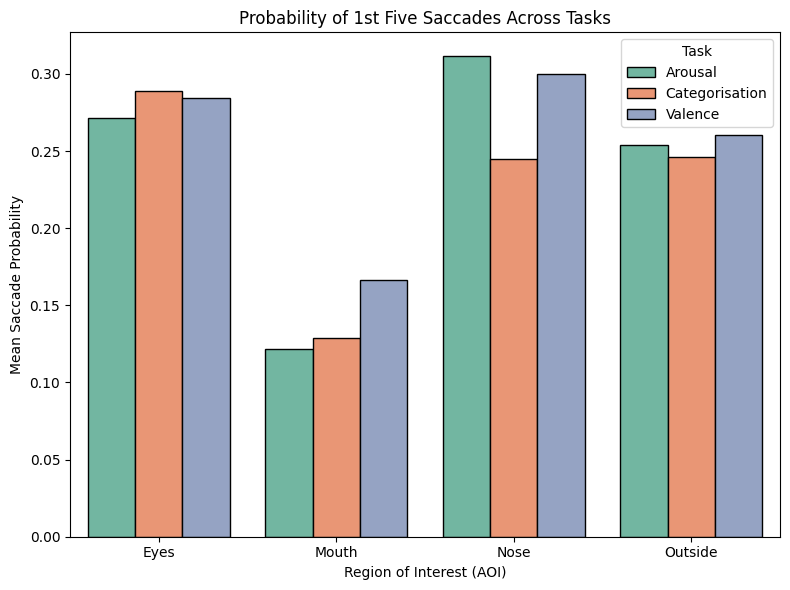

In [22]:
task_summary = (
    summary.groupby(["task", "AOI"])["probability"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=task_summary,
    x="AOI",
    y="probability",
    hue="task",
    palette="Set2",
    edgecolor="black"
)

plt.title("Probability of 1st Five Saccades Across Tasks")
plt.xlabel("Region of Interest (AOI)")
plt.ylabel("Mean Saccade Probability")
plt.legend(title="Task", loc="upper right")
plt.tight_layout()
plt.show()

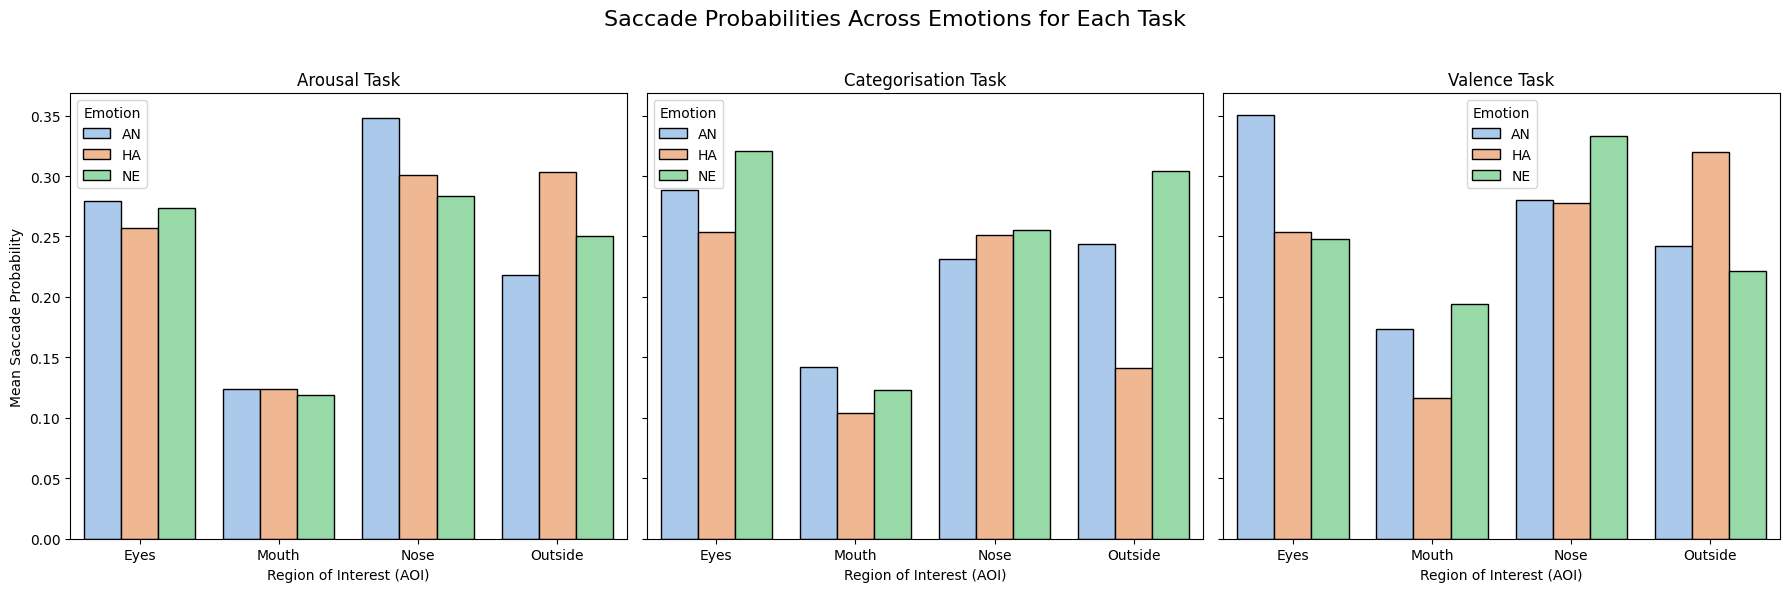

In [23]:

emotion_summary = (
    summary.groupby(["task", "emotion", "AOI"])["probability"]
    .mean()
    .reset_index()
)

tasks = ["Arousal", "Categorisation", "Valence"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, task in zip(axes, tasks):
    task_data = emotion_summary[emotion_summary["task"] == task]
    sns.barplot(
        data=task_data,
        x="AOI",
        y="probability",
        hue="emotion",
        palette="pastel",
        edgecolor="black",
        ax=ax
    )
    ax.set_title(f"{task} Task")
    ax.set_xlabel("Region of Interest (AOI)")
    ax.set_ylabel("Mean Saccade Probability")
    ax.legend(title="Emotion")

plt.suptitle("Saccade Probabilities Across Emotions for Each Task", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()